In [8]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from fusiondls.Profile import *
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [9]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [10]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [11]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 200, 1000)

## radas

In [7]:
rd_Ar = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


## SOLPS

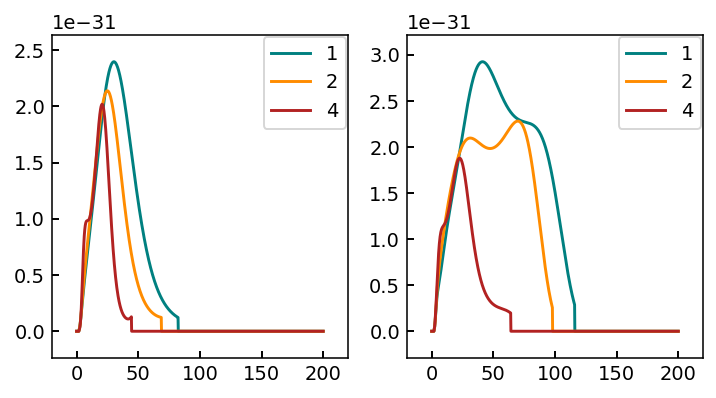

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [9]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

(-10.0, 200.0)

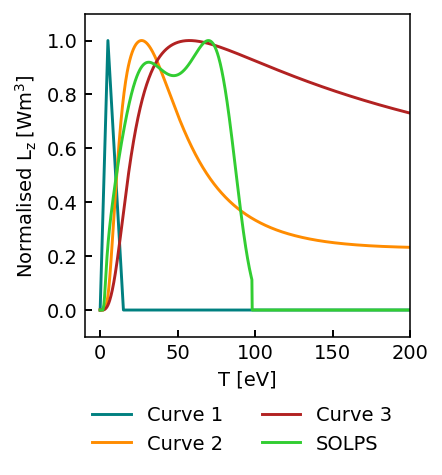

In [10]:
curves["set_outer"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e16],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

### Inner

(-10.0, 200.0)

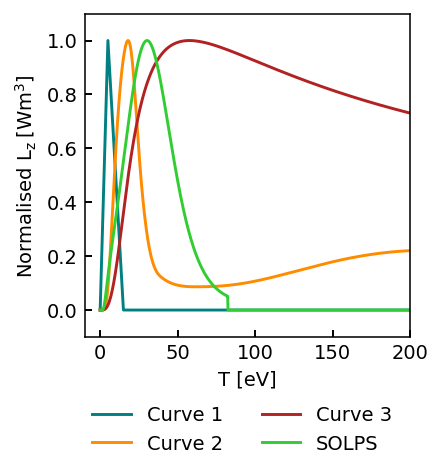

In [11]:
curves["set_inner"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e20],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

# Make profiles

Text(0.5, 1.0, 'Profile shapes')

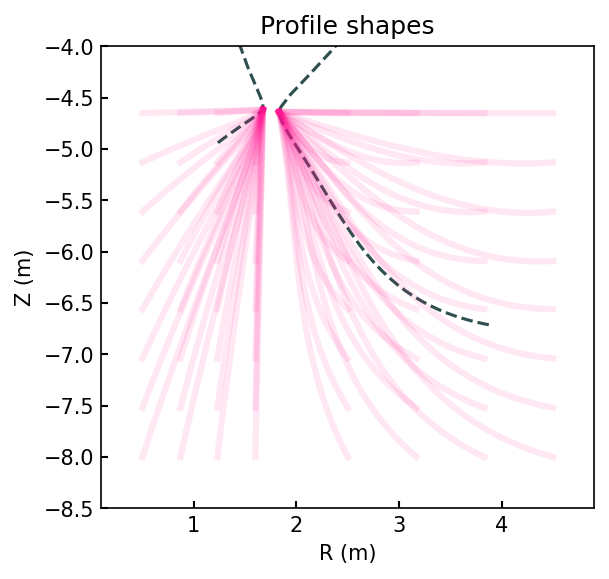

In [12]:
base_profile_inner = eqb_alt['100MW_innerar_midplanepuff']["inner_lower"][sepadd_select["inner_lower"]]
base_profile_outer = eqb_alt['100MW_innerar_midplanepuff']["outer_lower"][sepadd_select["outer_lower"]]

res = 4
xpoints_inner = np.linspace(0.5, 1.6, res).round(2)
ypoints_inner = np.linspace(-4.65, -8, res*2).round(2)

xpoints_outer = np.linspace(2.5, 4.5, res).round(2)
ypoints_outer = np.linspace(-4.65, -8, res*2).round(2)

profiles_inner = {}
profiles_outer = {}

for x in xpoints_outer:
    profiles_outer[x] = {}
    for y in ypoints_outer:
        p2 = base_profile_outer.copy()
        offsets = p2.get_offsets_strike_point([1, 0.6, 0.59, 0], x, y)
        p2.offset_control_points(offsets, verbose = False)
        p2.recalculate_topology(verbose = False)
        profiles_outer[x][y] = p2
        
for x in xpoints_inner:
    profiles_inner[x] = {}
    for y in ypoints_inner:
        p2 = base_profile_inner.copy()
        offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.1, 0], x, y)
        p2.offset_control_points(offsets, verbose = False)
        p2.recalculate_topology(verbose = False)
        profiles_inner[x][y] = p2

fig, ax = plt.subplots(dpi = 150)
ax.plot(base_profile_inner["R"], base_profile_inner["Z"], ls = "--", c = "darkslategrey")
ax.plot(base_profile_outer["R"], base_profile_outer["Z"], ls = "--", c = "darkslategrey")

for x in xpoints_outer:
    for y in ypoints_outer:
        profiles_outer[x][y].plot(ax = ax, mode = "RZ", color = "deeppink", ls = "-", lw = 3, alpha = 0.1)
        
for x in xpoints_inner:
    for y in ypoints_inner:
        profiles_inner[x][y].plot(ax = ax, mode = "RZ", color = "deeppink", ls = "-", lw = 3, alpha = 0.1)

ax.set_ylim(-8.5, -4.0)
# ax.set_xlim(1.5, 8)
# plt.plot(p2["R_original"], p2["Z_original"])
ax.set_aspect("equal")
ax.set_title("Profile shapes")



# Run DLS

In [22]:
def run_DLS(constants_input, profile, SparRange, slc, cvar, region, sepadd, 
            hflux_corr=1, Ctol = 1e-4, Ttol = 1e-4, atol = 1e-10, rtol = 1e-5):
    if "cooling_curve" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")

    df = slc.get_1d_poloidal_data(
        ["Ne"], sepadd=sepadd, region=region, target_first=True
    )
    nu = df["Ne"].iloc[-1]

    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=SparRange,
        qpllu0=3.42e8,
        nu0=nu,
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve(
            "Ar", region, sepadd=sepadd, plot=False
        ),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        atol = atol,
        rtol = rtol,
        Ctol = Ctol,
        Ttol = Ttol,
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )
    
    try:
        out = run_dls(
            dataclasses.replace(inputs, **constants_input),
            MagneticGeometry.from_profile(profile),
        )

    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(
        slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
    )

## Run baseline

## Initialise

In [14]:
nested_dict = lambda: defaultdict(nested_dict)
store_outer = nested_dict()
store_inner = nested_dict()
num_locations = 3
Ttol = 1e-3
Ctol = 1e-3

### Inner

In [15]:
rtols = [1e-4, 1e-5, 1e-6]
atols = [1e-6, 1e-10]

atols

[1e-06, 1e-10]

In [18]:
study = "inner"
region = "inner_lower"

rtols = [1e-4, 1e-5]
atols = [1e-5, 1e-6]

curve = "Curve 1"
for rtol in rtols:
    for atol in atols:
        base_profile_inner = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
        d = base_profile_inner
        SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], num_locations) # 
        SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]
        
        input = dict(cooling_curve = curves["set_inner"][curve])
        out, comp = run_DLS(input, base_profile_inner, SparRange, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1,
                            atol = atol, rtol = rtol)  
        store_inner[rtol][atol] = out
    

TypeError: run_DLS() got an unexpected keyword argument 'atol'

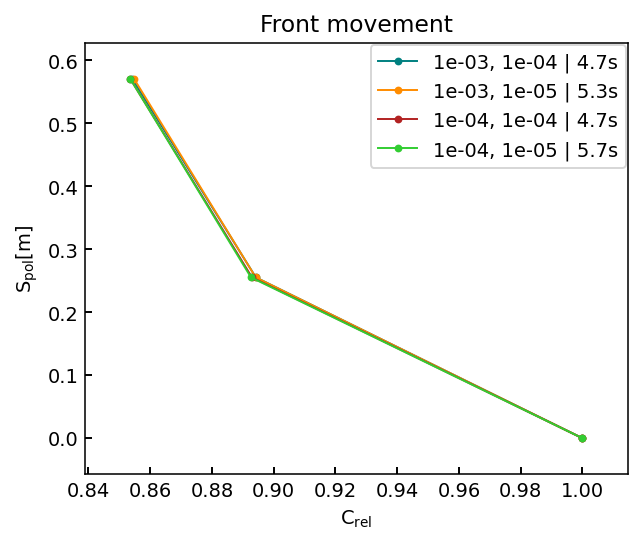

In [25]:
fig, ax = plt.subplots()

for rtol in rtols:
    for atol in atols:
        deck = DLScasedeck(store_inner[rtol][atol])
        speed = store_inner[rtol][atol]["runtime"]
        deck.plot_front_movement(ax = ax, label = f"{rtol:.0e}, {atol:.0e} | {speed:.1f}s", relative = True)
        
ax.legend()

# Diagnose strike point study

In [22]:
ypoints_outer

array([-4.65, -5.13, -5.61, -6.09, -6.56, -7.04, -7.52, -8.  ])

In [20]:
def make_SparRange(mode = "equally_spaced"):
    
    if mode == "equally_spaced":
        d = base_profile_inner
        Spol_Xpoint = d["Spol"][d["Xpoint"]]
        SpolRange_low = np.linspace(0, Spol_Xpoint/2, 2)
        SpolRange_high = np.linspace(Spol_Xpoint/2, Spol_Xpoint, num_locations)
        SpolRange = np.concatenate([SpolRange_low, SpolRange_high])
        SparRange_inner = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]
        SparRange_inner = np.unique(SparRange_inner)  # Drop duplicates

        d = base_profile_outer
        Spol_Xpoint = d["Spol"][d["Xpoint"]]
        SpolRange_low = np.linspace(0, Spol_Xpoint/2, 2)
        SpolRange_high = np.linspace(Spol_Xpoint/2, Spol_Xpoint, num_locations)
        SpolRange = np.concatenate([SpolRange_low, SpolRange_high])
        SparRange_outer = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]
        SparRange_outer = np.unique(SparRange_outer)  # Drop duplicates

    elif mode == "target_and_xpoint":
        SparRange_inner = [0, base_profile_inner["S"][base_profile_inner["Xpoint"]]]
        SparRange_outer = [0, base_profile_outer["S"][base_profile_outer["Xpoint"]]]

    elif mode == "target":
        SparRange_inner = [0]
        SparRange_outer = [0]
        
    return SparRange_inner, SparRange_outer

# SparRange_inner, SparRange_outer = make_SparRange("equally_spaced")
# SparRange_inner, SparRange_outer = make_SparRange("target")
SparRange_inner, SparRange_outer = make_SparRange("target_and_xpoint")

In [32]:
study = "outer"
region = "outer_lower"
curve = "Curve 1"
store = []
tests = [[2.50, -6.09]]

# for x in xpoints_outer:
#     for y in ypoints_outer:

for test in tests:
        x, y = test
        print(f"Solving profile {x:.2f}, {y:.2f} ------")
        input = dict(cooling_curve=curves["set_outer"][curve], Ctol=Ctol, Ttol=Ttol)
        profile = profiles_outer[x][y]

        out, comp = run_DLS(
            input,
            profile,
            [0],
            store_slc[case],
            "density",
            region,
            sepadd_select[region],
            hflux_corr=1,
            atol=atol,
            rtol=rtol,
            Ctol=Ctol,
            Ttol=Ttol,
        )
        store.append(out)

    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving profile 2.50, -6.09 ------
Solving...0.00...Complete in 2.6 seconds


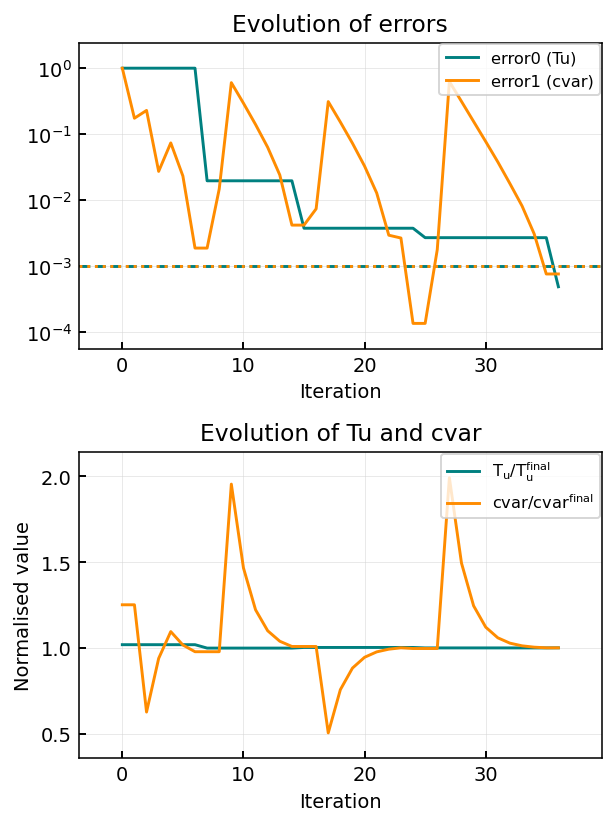

In [51]:
FrontLocation(store[0], index = 0).plot_performance()

In [53]:
FrontLocation.attributes

AttributeError: type object 'FrontLocation' has no attribute 'attributes'

In [ ]:
store[0]["logs"]

logs = store[0]["logs"]
front_positions = list(logs.keys())
log = logs[front_positions[0]]

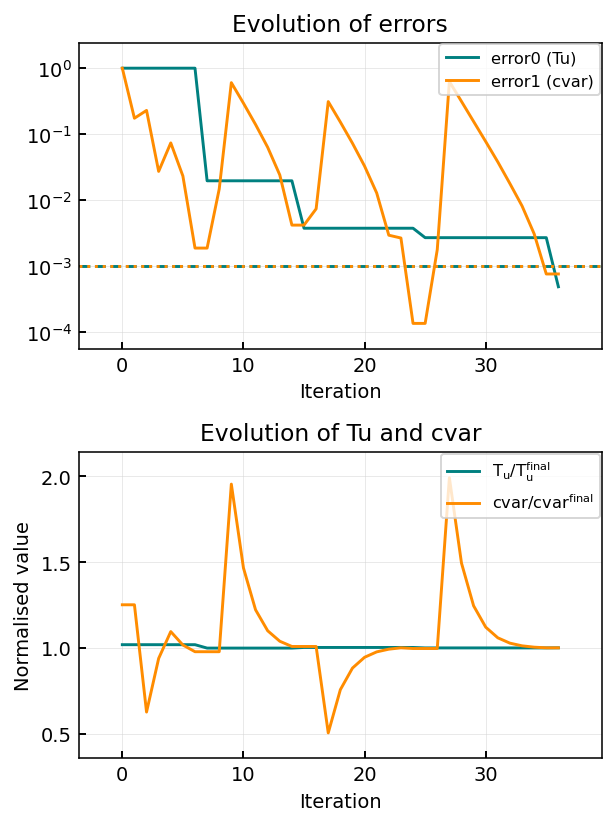

In [48]:
log = dls.log

def plot_performance(log):
    
    fig, axes = plt.subplots(2,1, figsize = (4.5,6))

    axes[0].set_title("Evolution of errors")
    axes[0].plot(abs(np.array(log["error0"])), label = "error0 (Tu)", color = "teal")
    axes[0].plot(abs(np.array(log["error1"])), label = "error1 (cvar)", color = "darkorange")
    axes[0].set_yscale("log")
    xlims = axes[0].get_xlim()
    axes[0].hlines(store[0].inputs.Ttol, *xlims, color = "teal", ls = "--")
    axes[0].hlines(store[0].inputs.Ctol, *xlims, color = "darkorange", ls = ":")
    axes[0].set_xlim(xlims)

    axes[1].set_title("Evolution of Tu and cvar")
    axes[1].plot(log["Tu"]/log["Tu"][-1], label = "$T_u/T_u^{final}$")
    axes[1].plot(log["cvar"]/log["cvar"][-1], label = "$cvar/cvar^{final}$")
    axes[1].set_ylabel("Normalised value")

    for ax in axes:
        ax.legend(loc = "upper right", fontsize = "small")
        ax.set_xlabel("Iteration")
        ax.grid()

    fig.tight_layout()
    
plot_performance(dls.log)

Text(0, 0.5, 'Normalised value')

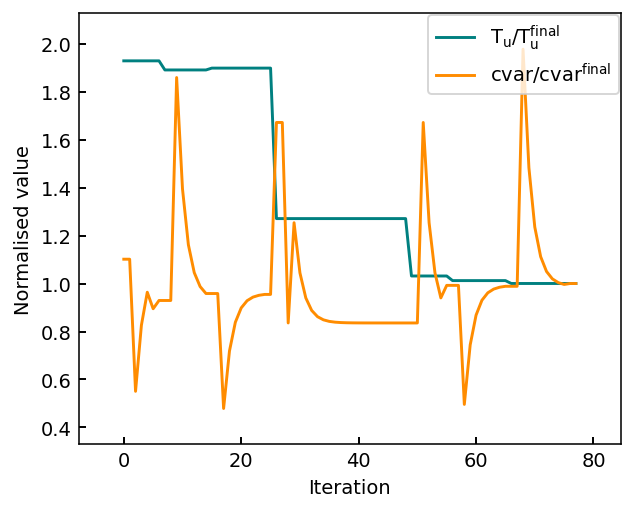

In [66]:
fig, ax = plt.subplots()
ax.plot(log["Tu"]/log["Tu"][-1], label = "$T_u/T_u^{final}$")
ax.plot(log["cvar"]/log["cvar"][-1], label = "$cvar/cvar^{final}$")
ax.legend(loc = "upper right")
# ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("Normalised value")

In [33]:
deck = FrontLocationScan(store[0])
dls = deck.FrontLocations[0]

dls.stats

{'cvar': 1.1369483413006028e+20,
 'kappa0': 2861.09503501397,
 'Bf': 2.807659334669023,
 'Bx': 3.2847277407680084,
 'Beff': 2.807166855273247,
 'BxBt': 1.1699167702463533,
 'BxBteff': 1.1701220162947088,
 'Lc': 6.944853365791707,
 'Wradial': 18104855.49860211,
 'Tu': 88.45255082344458,
 'avgB_ratio': 1.0544293732238736,
 'upstream_rad': 5.751118859113014,
 'W_Tu': 0.19715622545893285,
 'W_Tu_simple': 0.3203983493958504,
 'curveclip': 7252853475914.425}